In [1]:
# Special directive to Jupiter Notebook
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob

import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

##Import any other packages you may need here
from itertools import chain
from random import sample 
import scipy
# Read and show xray
from skimage.io import imread, imshow
from skimage import io

import pydicom
from itertools import chain

# Recommended to correct an error in the fig, ax
from ipykernel import kernelapp as app

EDA is open-ended, and it is up to you to decide how to look at different ways to slice and dice your data. A good starting point is to look at the requirements for the FDA documentation in the final part of this project to guide (some) of the analyses you do. 

This EDA should also help to inform you of how pneumonia looks in the wild. E.g. what other types of diseases it's commonly found with, how often it is found, what ages it affects, etc. 

Note that this NIH dataset was not specifically acquired for pneumonia. So, while this is a representation of 'pneumonia in the wild,' the prevalence of pneumonia may be different if you were to take only chest x-rays that were acquired in an ER setting with suspicion of pneumonia. 

Perform the some EDA:
* The patient demographic data such as gender, age, patient position,etc. (as it is available)
* The x-ray views taken (i.e. view position)
* The number of cases including: 
    * number of pneumonia cases,
    * number of non-pneumonia cases
* The distribution of other diseases that are comorbid with pneumonia
* Number of disease per patient 
* Pixel-level assessments of the imaging data for healthy & disease states of interest (e.g. histograms of intensity values) and compare distributions across diseases.

Note: use full NIH data to perform the first a few EDA items and use `sample_labels.csv` for the pixel-level assassements. 

Also, **describe your findings and how will you set up the model training based on the findings.**

In [3]:
## Below is some helper code to read data for you.
## Load NIH data by passing the path to the file

# Path of the file to read
filepath = '/data/Data_Entry_2017.csv'

# Read the file into a variable all_xray_df
all_xray_df = pd.read_csv(filepath)


all_xray_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],OriginalImagePixelSpacing[x,y],Unnamed: 11
58250,00014398_039.png,Effusion,39,14398,57,F,AP,2500,2048,0.168,0.168,NaN
15176,00003989_003.png,Cardiomegaly,3,3989,65,F,AP,3056,2544,0.139,0.139,NaN
610,00000149_008.png,No Finding,8,149,70,M,PA,2682,2689,0.143,0.143,NaN


### Exploriatory Data Analysis
**1. Label distribution on the data**

In [4]:
## Here I'm just going to split up my "Finding Labels" column by the | symbol separator 
# so that I have one column per disease in my dataframe,
# with a binary flag. This makes EDA a lot easier! 

# maps/gets each row of the Finding label column and split it using the '|' character as separable. 
all_labels = np.unique(list(chain(*all_xray_df['Finding Labels'].map(lambda x: x.split('|')).tolist())))
all_labels = [x for x in all_labels if len(x)>0]
print('All Labels ({}): {}'.format(len(all_labels), all_labels))
for label in all_labels:
    if len(label)>1: # leave out empty labels
        all_xray_df[label] = all_xray_df['Finding Labels'].map(lambda finding: 1.0 if label in finding else 0)
        

All Labels (15): ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'No Finding', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


In [5]:
# Distribution of diseases
# all_labels variable is a list of all these columns
all_xray_df[all_labels].sum()/len(all_xray_df)

Atelectasis           0.103095
Cardiomegaly          0.024759
Consolidation         0.041625
Edema                 0.020540
Effusion              0.118775
Emphysema             0.022440
Fibrosis              0.015037
Hernia                0.002025
Infiltration          0.177435
Mass                  0.051570
No Finding            0.538361
Nodule                0.056466
Pleural_Thickening    0.030191
Pneumonia             0.012763
Pneumothorax          0.047289
dtype: float64

[Text(0, 0.5, 'Number of Images with Label')]

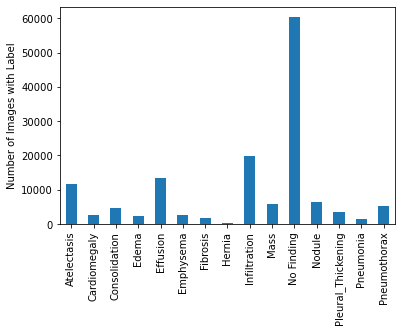

In [6]:
ax = all_xray_df[all_labels].sum().plot(kind='bar')
ax.set(ylabel = 'Number of Images with Label')

As expected pneumonia only constitute only 1% of the dataset. 50% of the data constitute no findings and the rest 40% are concurrent diseases. Of the 40% concurrent diseases, Infilteration, Effusion and Atectasis are the most common. Overall , negative finding with respect to pneumonia classes is 90% of the dataset.

### 1.1 Absolute count of each disease
That occured concurrently with pneumonia


In [7]:
# Pull the first disease
comorb1 = all_xray_df['Image Index'][0]
comorb1

'00000001_000.png'

In [8]:
#img = imread(comorb1)

In [9]:
# Absolute total count of each disease
diseases_freq ={}
all_labels = ['Atelectasis','Effusion','Pneumothorax','Infiltration','Cardiomegaly','Mass','Nodule']
for i in all_labels:
    # Use each disease as the key, then count each time I see the key with pnueumonia
    diseases_freq[i] = len(all_xray_df[all_xray_df.Pneumonia==1][all_xray_df[i]==1])


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


In [10]:
diseases_freq

{'Atelectasis': 262,
 'Effusion': 269,
 'Pneumothorax': 41,
 'Infiltration': 605,
 'Cardiomegaly': 41,
 'Mass': 71,
 'Nodule': 70}

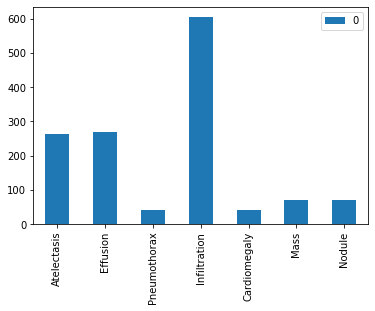

In [11]:
# Creating dataframe by converting dict to list of items
ds = pd.DataFrame.from_dict(diseases_freq, orient='index').plot(kind='bar')


### 1.2 Thirty most concurrent diseases with Pneumonia

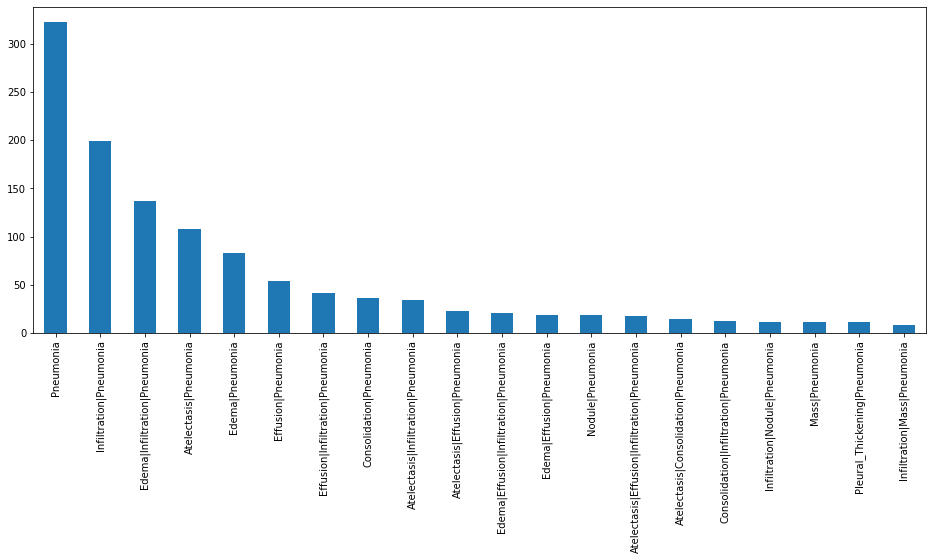

In [12]:
## Since there are many combinations of potential findings, I'm going to look at the 30 most common co-occurrences:
plt.figure(figsize=(16,6))
# First, set a condition(all_xray_df.pneumonia) for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot
all_xray_df[all_xray_df.Pneumonia==1]['Finding Labels'].value_counts()[0:20].plot(kind='bar')


The 30 most common concurrent disease with pneumonia are shown. Infilteration, Effusion and Atectasis being the most common concurrences.

### 2. Basic demographics

**2.1 Gender distribution**

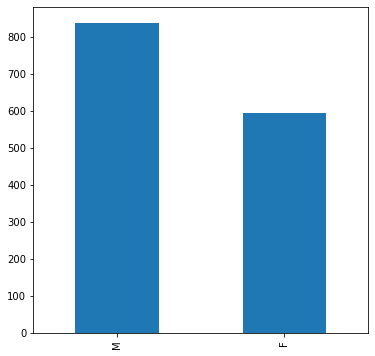

In [13]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia==1]['Patient Gender'].value_counts().plot(kind='bar')

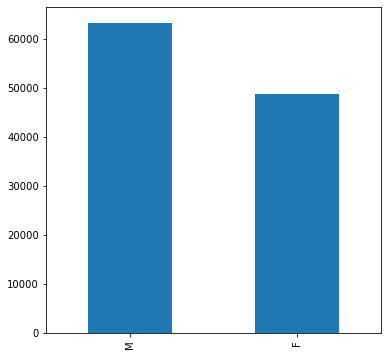

In [14]:
# Plot patient demographic data such as gender
plt.figure(figsize=(6,6))
all_xray_df['Patient Gender'].value_counts().plot(kind='bar')

The number males in the test were marginally more than that of females by ratio 3:2. This ration remain consistent in the overal dataset and the pneumonia cohort

**2.2 Patient Age**

Text(0.5, 1.0, 'Ages group trained on')

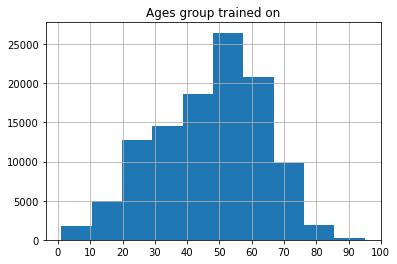

In [15]:
# Patient demographic data- my algorithm was trained on
#plt.figure(figsize=(10,6))
# First, set a condition(all_xray_df['Patient Age'] <100 for accessing the data object(all_xray_df) from Pandas, then that combined with age with plot 
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'].hist(bins=10)
plt.xticks(list(range(0,101,10)))
plt.title('Ages group trained on')


The device was trained on people of age below 80 years.

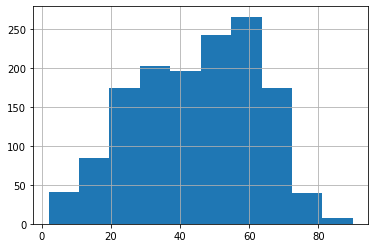

In [16]:
all_xray_df[all_xray_df['Patient Age']<100]['Patient Age'][all_xray_df.Pneumonia ==1].hist(bins=10)

**2.4 Age distribution for Pneumonia cases only**

This graph show that 50- 60 years age group most affected by pneumonia

**2.3 View Position of chest x ray with Pneumonia**

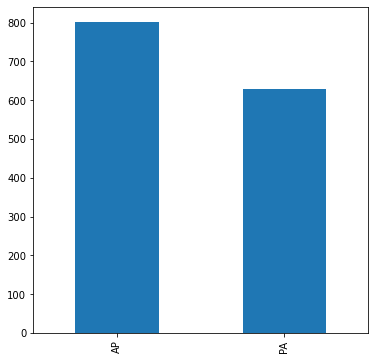

In [17]:
# Patient Position distribution of Pneumonia
plt.figure(figsize=(6,6))
all_xray_df[all_xray_df.Pneumonia ==1]['View Position'].value_counts().plot(kind='bar')


There were more chest x-ray AP than PA views with people who have pneumonia

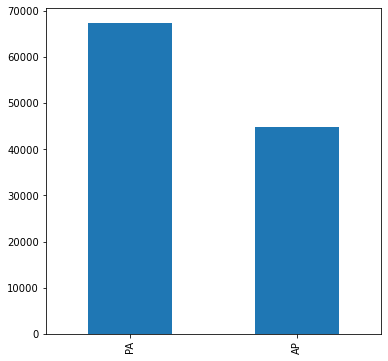

In [18]:
#  Patient position distribution of the dataset
plt.figure(figsize=(6,6))
all_xray_df['View Position'].value_counts().plot(kind='bar')


PA chest X-rays are are common than than AP views in this dataset.

### Number of concurrent disease with pneumonia

In [19]:
comorb = pd.read_csv('comorbidity.csv')

In [20]:
comorb.head()

,Unnamed: 0,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImage[Width,Height],...,Infiltration,Mass,No Finding,Nodule,Pleural_Thickening,Pneumonia,Pneumothorax,pneumonia_class,ground_truth,comorbidity
0,0,00000001_000.png,Cardiomegaly,0,1,58,M,PA,2682,2749,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
1,1,00000001_001.png,Cardiomegaly|Emphysema,1,1,58,M,PA,2894,2729,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,1.0
2,2,00000001_002.png,Cardiomegaly|Effusion,2,1,58,M,PA,2500,2048,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,2.0
3,3,00000002_000.png,No Finding,0,2,81,M,PA,2500,2048,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0
4,4,00000003_000.png,Hernia,0,3,81,F,PA,2582,2991,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Not Pneumonia,normal,0.0


In [21]:
# Create data I will use for my plot
comorb[comorb.Pneumonia==1]['comorbidity'].value_counts()

1.0    651
0.0    465
2.0    249
3.0     56
4.0      8
5.0      2
Name: comorbidity, dtype: int64

In [22]:
# Sort them into order and get the values
comorb_count= comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index()
y =comorb_count.values
y

array([465, 651, 249,  56,   8,   2])

In [23]:
# Call index values here
x = comorb_count.index
x

Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

In [24]:
# Sort the index Index for x axis

comorb[comorb.Pneumonia==1]['comorbidity'].value_counts().sort_index().index


Float64Index([0.0, 1.0, 2.0, 3.0, 4.0, 5.0], dtype='float64')

Text(0, 0.5, 'num_of_patients')

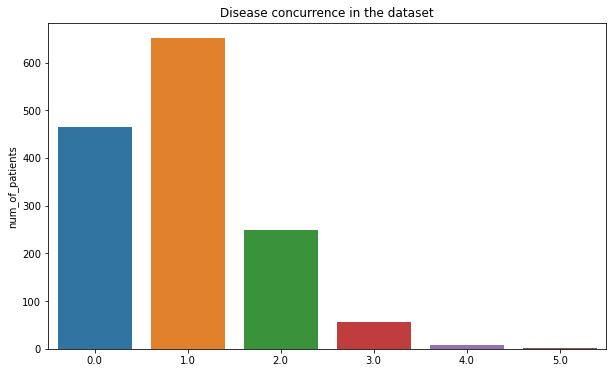

In [25]:
# Set the width and height of the figure
plt.figure(figsize=(10, 6))

# Add title
plt.title('Disease concurrence in the dataset')

# The comorbidity column is used to indentify the x axis and index for the y axis
sns.barplot(x=comorb_count.index, y=comorb_count.values)


plt.ylabel('num_of_patients')


50% of the patients had no concurrent disease. 

### Pixel-level data Analysis

In [26]:
## Load 'sample_labels.csv' data for pixel level assessments
sample_df = pd.read_csv('sample_labels.csv')
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
316,00001684_025.png,Atelectasis|Effusion,25,1684,058Y,M,AP,2500,2048,0.168,0.168
2902,00014292_000.png,No Finding,0,14292,028Y,M,PA,2544,3056,0.139,0.139
4288,00021172_000.png,No Finding,0,21172,023Y,F,PA,2992,2991,0.143,0.143


In [27]:
# Create paths to images and assign it to the variable paths

# x represent image index
paths = {os.path.basename(x): x for x in glob(os.path.join('/data/','images*/','images/', '*.png'))}

# Create a column path and populate it by mapping panda series index to thier image path
sample_df['path'] = sample_df['Image Index'].map(paths.get)
# Random sample of 3 images
sample_df.sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
146,00000820_003.png,Infiltration,3,820,042Y,M,AP,2500,2048,0.171,0.171,/data/images_001/images/00000820_003.png
3517,00017331_000.png,Infiltration,0,17331,019Y,M,AP,2500,2048,0.168,0.168,/data/images_008/images/00017331_000.png
2727,00013670_036.png,No Finding,36,13670,056Y,M,AP,2500,2048,0.168,0.168,/data/images_006/images/00013670_036.png


### 1. Assess disease pixel intensity
The focus is on the pixel intensity of pneumonia and the most frequent disease concurrences of pneumonia

### Plots of image and intensity values
**For a single row of image and  intensity values**


In [28]:
labels = ['Atelectasis', 'Cardiomegaly', 'Consolidation', 'Edema', 'Effusion', 'Emphysema', 'Fibrosis', 'Hernia', 'Infiltration', 'Mass', 'Nodule', 'Pleural_Thickening', 'Pneumonia', 'Pneumothorax']


### Pneumonia image and intensty plots

In [29]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pneumonia'].sample(3)


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,/data/images_006/images/00012667_000.png
2534,00012733_000.png,Pneumonia,0,12733,073Y,M,PA,2992,2991,0.143,0.143,/data/images_006/images/00012733_000.png
2422,00012158_025.png,Pneumonia,25,12158,047Y,F,PA,2992,2991,0.143,0.143,/data/images_006/images/00012158_025.png


In [30]:
p = sample_df[sample_df['Image Index'] == '00014201_008.png']
p


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2875,00014201_008.png,Pneumonia,8,14201,031Y,F,PA,2578,2845,0.143,0.143,/data/images_007/images/00014201_008.png


Since I have the image index I will do image and pixel analysis.

<function matplotlib.pyplot.show(*args, **kw)>

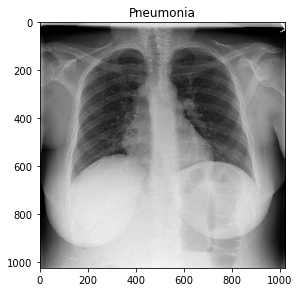

In [31]:
img =io.imread('/data/images_007/images/00014201_008.png')
imgplot = imshow(img)
img_title = plt.title('Pneumonia')
plt.show


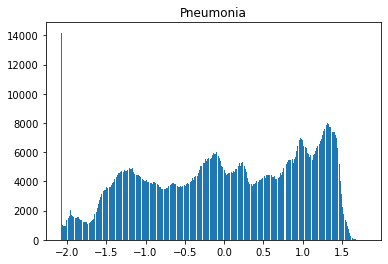

In [32]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumonia')
plt.show()

In [33]:
p1 = sample_df[sample_df['Image Index'] == '00012667_000.png']
p1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2522,00012667_000.png,Pneumonia,0,12667,007Y,F,PA,1804,1685,0.143,0.143,/data/images_006/images/00012667_000.png


<function matplotlib.pyplot.show(*args, **kw)>

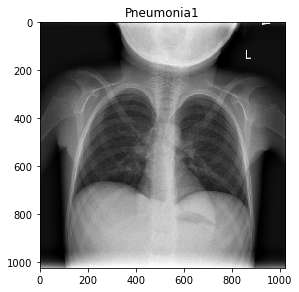

In [34]:
img =io.imread('/data/images_006/images/00012667_000.png')
imgplot = imshow(img)
img_title = plt.title('Pneumonia1')
plt.show

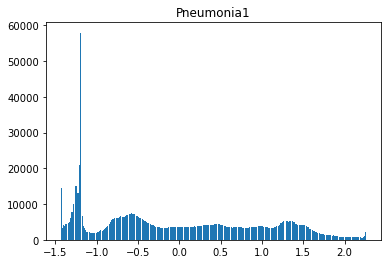

In [35]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumonia1')
plt.show()

Pneumonia has a mode of 8000 but the intensity seem flat from -1.5 to 1.5

### Infiltration image and intensty plots

In [36]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Infiltration'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
901,00004800_003.png,Infiltration,3,4800,045Y,F,PA,2048,2500,0.171,0.171,/data/images_003/images/00004800_003.png
229,00001255_018.png,Infiltration,18,1255,013Y,M,AP,2048,2500,0.171,0.171,/data/images_001/images/00001255_018.png
4244,00020904_010.png,Infiltration,10,20904,048Y,M,AP,3056,2544,0.139,0.139,/data/images_009/images/00020904_010.png


In [37]:
inf = sample_df[sample_df['Image Index'] == '00019576_024.png']
inf

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3963,00019576_024.png,Infiltration,24,19576,049Y,M,AP,2048,2500,0.168,0.168,/data/images_009/images/00019576_024.png


<function matplotlib.pyplot.show(*args, **kw)>

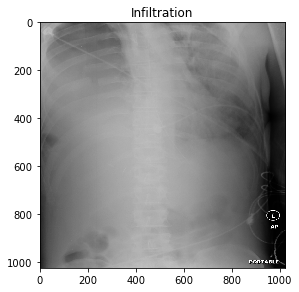

In [38]:
img = io.imread('/data/images_009/images/00019576_024.png')
imgplot = imshow(img)
img_title = plt.title('Infiltration')
plt.show


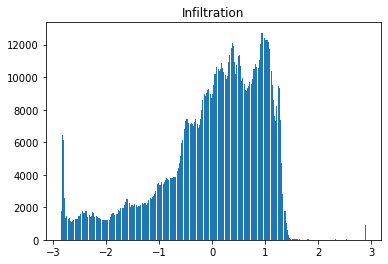

In [39]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Infiltration')
plt.show()

In [40]:
inf1 = sample_df[sample_df['Image Index'] == '00028402_000.png']
inf1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5278,00028402_000.png,Infiltration,0,28402,030Y,M,PA,2544,3056,0.139,0.139,/data/images_012/images/00028402_000.png


<function matplotlib.pyplot.show(*args, **kw)>

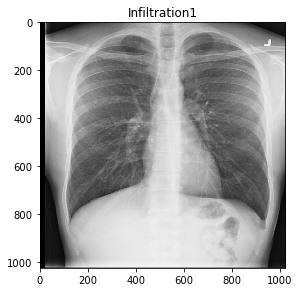

In [41]:
img = io.imread('/data/images_012/images/00028402_000.png')
imgplot = imshow(img)
img_title = plt.title('Infiltration1')
plt.show



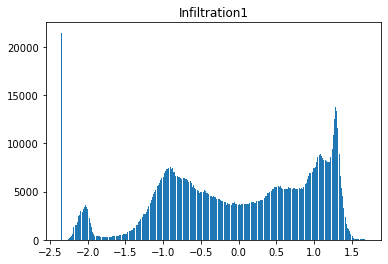

In [42]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Infiltration1')
plt.show()

Infiltration intensity is skewed consistently towards a positive std of 1.5 and the mode is 12000

### Atelectasis image and intensty plots

In [43]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Atelectasis'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3917,00019322_000.png,Atelectasis,0,19322,021Y,M,PA,2774,2625,0.143,0.143,/data/images_009/images/00019322_000.png
5509,00030059_006.png,Atelectasis,6,30059,069Y,M,AP,3056,2544,0.139,0.139,/data/images_012/images/00030059_006.png
4257,00020979_007.png,Atelectasis,7,20979,045Y,M,PA,2992,2991,0.143,0.143,/data/images_010/images/00020979_007.png


In [44]:
a = sample_df[sample_df['Image Index'] == '00020966_000.png']
a


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4252,00020966_000.png,Atelectasis,0,20966,052Y,M,PA,2930,2961,0.143,0.143,/data/images_010/images/00020966_000.png


<function matplotlib.pyplot.show(*args, **kw)>

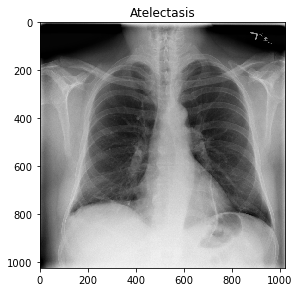

In [45]:
img = io.imread('/data/images_010/images/00020966_000.png')
imgplot = imshow(img)
img_title = plt.title('Atelectasis')
plt.show


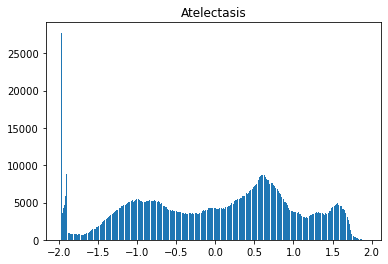

In [46]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Atelectasis')
plt.show()

In [47]:
a1 = sample_df[sample_df['Image Index'] == '00005742_001.png']
a1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1098,00005742_001.png,Atelectasis,1,5742,060Y,M,AP,2500,2048,0.171,0.171,/data/images_003/images/00005742_001.png


<function matplotlib.pyplot.show(*args, **kw)>

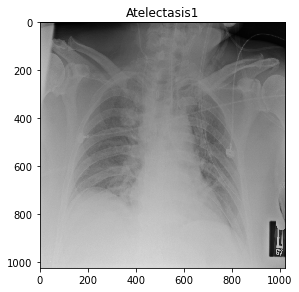

In [48]:
img = io.imread('/data/images_003/images/00005742_001.png')
imgplot = imshow(img)
img_title = plt.title('Atelectasis1')
plt.show


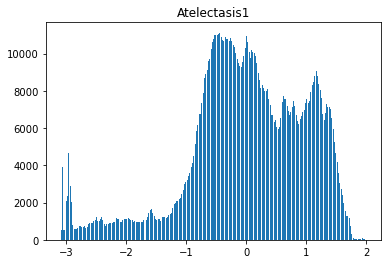

In [49]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Atelectasis1')
plt.show()

Triple peak with mode of 12,000 at or near the mean

### Cardiomegaly image and intensty plots

In [50]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Cardiomegaly'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3432,00016926_003.png,Cardiomegaly,3,16926,063Y,F,PA,2750,2885,0.143,0.143,/data/images_008/images/00016926_003.png
1484,00007729_000.png,Cardiomegaly,0,7729,059Y,F,PA,2048,2500,0.168,0.168,/data/images_004/images/00007729_000.png
2161,00011140_015.png,Cardiomegaly,15,11140,040Y,F,AP,2500,2048,0.168,0.168,/data/images_005/images/00011140_015.png


In [51]:
c = sample_df[sample_df['Image Index'] == '00007945_000.png']
c

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1520,00007945_000.png,Cardiomegaly,0,7945,035Y,F,PA,2048,2500,0.168,0.168,/data/images_004/images/00007945_000.png


<function matplotlib.pyplot.show(*args, **kw)>

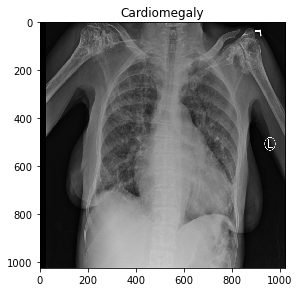

In [52]:
img = io.imread('/data/images_004/images/00006875_008.png')
imgplot = imshow(img)
img_title = plt.title('Cardiomegaly')
plt.show


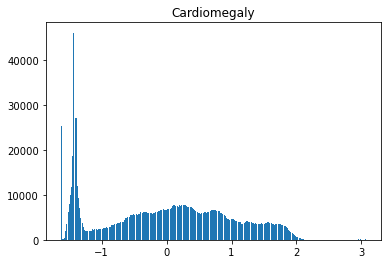

In [53]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Cardiomegaly')
plt.show()

In [54]:
c1 = sample_df[sample_df['Image Index'] == '00007729_000.png']
c1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1484,00007729_000.png,Cardiomegaly,0,7729,059Y,F,PA,2048,2500,0.168,0.168,/data/images_004/images/00007729_000.png


<function matplotlib.pyplot.show(*args, **kw)>

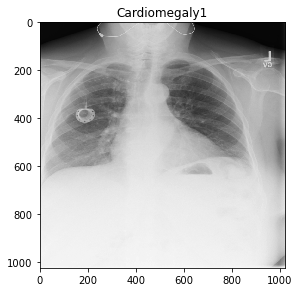

In [55]:
img = io.imread('/data/images_004/images/00007729_000.png')
imgplot = imshow(img)
img_title = plt.title('Cardiomegaly1')
plt.show

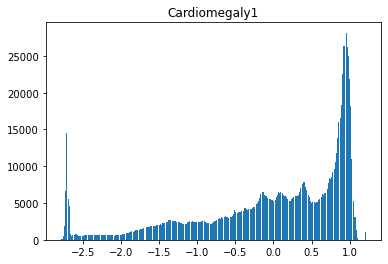

In [56]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Cardiomegaly1')
plt.show()

### Consolidation image and intensty plots

In [57]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Consolidation'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3399,00016778_017.png,Consolidation,17,16778,026Y,M,AP,3056,2544,0.139,0.139,/data/images_008/images/00016778_017.png
1919,00010007_169.png,Consolidation,169,10007,059Y,M,AP,2500,2048,0.168,0.168,/data/images_005/images/00010007_169.png
3719,00018251_014.png,Consolidation,14,18251,006Y,M,AP,2048,2500,0.168,0.168,/data/images_008/images/00018251_014.png


In [58]:
co = sample_df[sample_df['Image Index'] == '00000116_019.png']
co

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
20,00000116_019.png,Consolidation,19,116,075Y,F,AP,2500,2048,0.168,0.168,/data/images_001/images/00000116_019.png


<function matplotlib.pyplot.show(*args, **kw)>

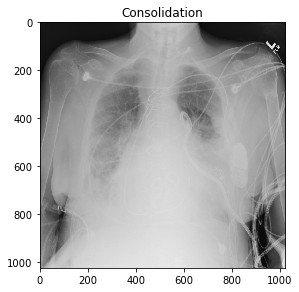

In [59]:
img = io.imread('/data/images_001/images/00000116_019.png')
imgplot = imshow(img)
img_title = plt.title('Consolidation')
plt.show

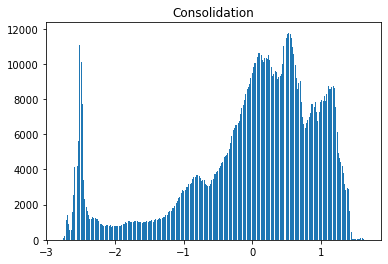

In [60]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Consolidation')
plt.show()

In [61]:
co1 = sample_df[sample_df['Image Index'] == '00015045_018.png']
co1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3055,00015045_018.png,Consolidation,18,15045,029Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00015045_018.png


<function matplotlib.pyplot.show(*args, **kw)>

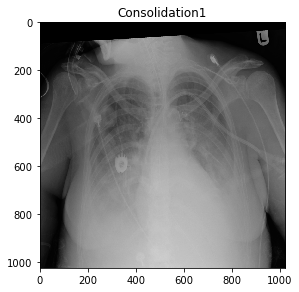

In [62]:
img = io.imread('/data/images_007/images/00015045_018.png')
imgplot = imshow(img)
img_title = plt.title('Consolidation1')
plt.show

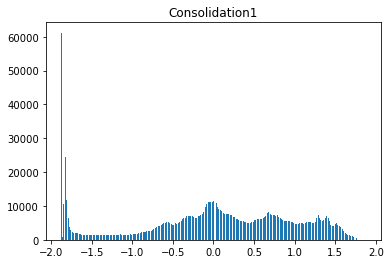

In [63]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Consolidation1')
plt.show()

### Edema image and intensty plots

In [64]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Edema'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5090,00027045_002.png,Edema,2,27045,060Y,M,AP,3056,2544,0.139,0.139,/data/images_011/images/00027045_002.png
3169,00015606_006.png,Edema,6,15606,017Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00015606_006.png
882,00004659_000.png,Edema,0,4659,035Y,F,AP,2500,2048,0.171,0.171,/data/images_003/images/00004659_000.png


In [65]:
e = sample_df[sample_df['Image Index'] == '00015799_007.png']
e

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3211,00015799_007.png,Edema,7,15799,068Y,F,AP,2500,2048,0.168,0.168,/data/images_007/images/00015799_007.png


<function matplotlib.pyplot.show(*args, **kw)>

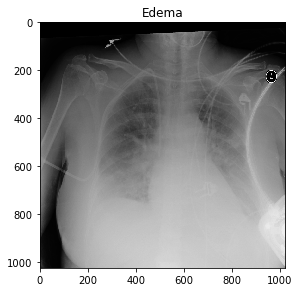

In [66]:
img = io.imread('/data/images_007/images/00015799_007.png')
imgplot = imshow(img)
img_title = plt.title('Edema')
plt.show


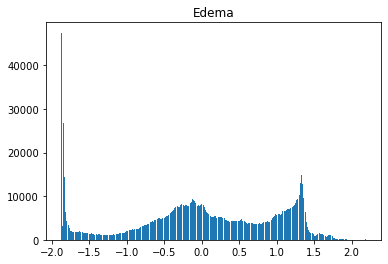

In [67]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Edema')
plt.show()

### Effusion image and intensty plots

In [68]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Effusion'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1351,00007034_016.png,Effusion,16,7034,031Y,F,PA,2021,2021,0.194311,0.194311,/data/images_004/images/00007034_016.png
3351,00016522_022.png,Effusion,22,16522,029Y,M,AP,2500,2048,0.168000,0.168000,/data/images_008/images/00016522_022.png
1823,00009608_014.png,Effusion,14,9608,030Y,M,AP,2048,2500,0.168000,0.168000,/data/images_005/images/00009608_014.png


In [69]:
e = sample_df[sample_df['Image Index'] == '00018555_003.png']
e

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3779,00018555_003.png,Effusion,3,18555,015Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00018555_003.png


<function matplotlib.pyplot.show(*args, **kw)>

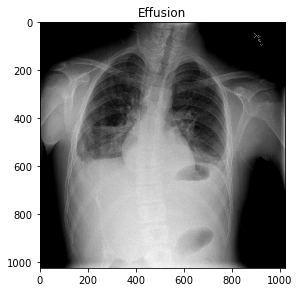

In [70]:
img = io.imread('/data/images_009/images/00018555_003.png')
imgplot = imshow(img)
img_title = plt.title('Effusion')
plt.show

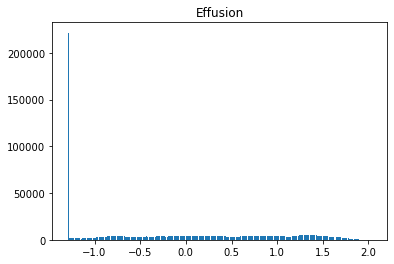

In [71]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Effusion')
plt.show()

In [117]:
e1 = sample_df[sample_df['Image Index'] == '00009608_014.png']
e1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1823,00009608_014.png,Effusion,14,9608,030Y,M,AP,2048,2500,0.168,0.168,/data/images_005/images/00009608_014.png


<function matplotlib.pyplot.show(*args, **kw)>

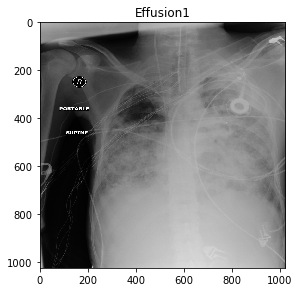

In [118]:
img = io.imread('/data/images_005/images/00009608_014.png')
imgplot = imshow(img)
img_title = plt.title('Effusion1')
plt.show

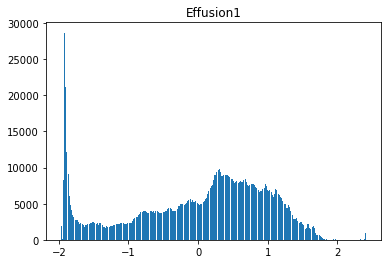

In [119]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Effusion1')
plt.show()

Mode= 10,000 at  0.3 and std of -2 to 2

### Fibrosis image and intensty plots

In [72]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Fibrosis'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
384,00001998_000.png,Fibrosis,0,1998,058Y,F,PA,2048,2500,0.171,0.171,/data/images_002/images/00001998_000.png
955,00004973_001.png,Fibrosis,1,4973,069Y,M,PA,2500,2048,0.171,0.171,/data/images_003/images/00004973_001.png
2147,00011087_001.png,Fibrosis,1,11087,082Y,F,PA,2992,2991,0.143,0.143,/data/images_005/images/00011087_001.png


In [110]:
f = sample_df[sample_df['Image Index']=='00001998_000.png']
f

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
384,00001998_000.png,Fibrosis,0,1998,058Y,F,PA,2048,2500,0.171,0.171,/data/images_002/images/00001998_000.png


<function matplotlib.pyplot.show(*args, **kw)>

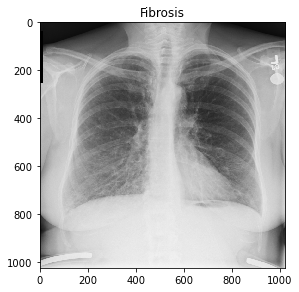

In [111]:
img = io.imread('/data/images_002/images/00001998_000.png')
imgplot = imshow(img)
img_title = plt.title('Fibrosis')
plt.show



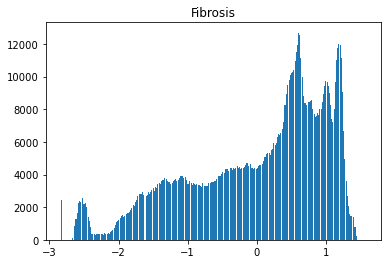

In [113]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Fibrosis')
plt.show()

In [114]:
f1 = sample_df[sample_df['Image Index']=='00004973_001.png']
f1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
955,00004973_001.png,Fibrosis,1,4973,069Y,M,PA,2500,2048,0.171,0.171,/data/images_003/images/00004973_001.png


<function matplotlib.pyplot.show(*args, **kw)>

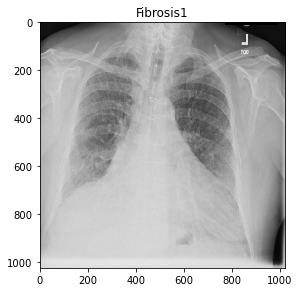

In [115]:
img = io.imread('/data/images_003/images/00004973_001.png')
imgplot = imshow(img)
img_title = plt.title('Fibrosis1')
plt.show

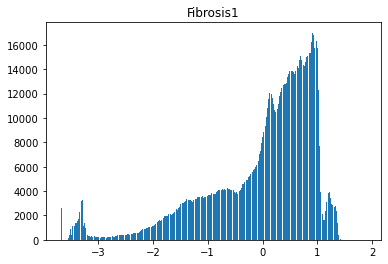

In [116]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Fibrosis1')
plt.show()

Mode is between 14000 -17,000 at std 1 and positively skewed.

### Hernia image and intensty plots

In [76]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Hernia'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1546,00008015_000.png,Hernia,0,8015,062Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00008015_000.png
1479,00007712_002.png,Hernia,2,7712,080Y,F,PA,2678,2665,0.143,0.143,/data/images_004/images/00007712_002.png
1418,00007352_000.png,Hernia,0,7352,056Y,M,PA,2500,2048,0.168,0.168,/data/images_004/images/00007352_000.png


In [77]:
h = sample_df[sample_df['Image Index']=='00008694_002.png']
h


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1662,00008694_002.png,Hernia,2,8694,054Y,F,AP,2500,2048,0.168,0.168,/data/images_004/images/00008694_002.png


<function matplotlib.pyplot.show(*args, **kw)>

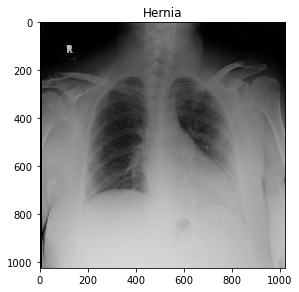

In [78]:
img = io.imread('/data/images_004/images/00008694_002.png')
imgplot = imshow(img)
img_title = plt.title('Hernia')
plt.show


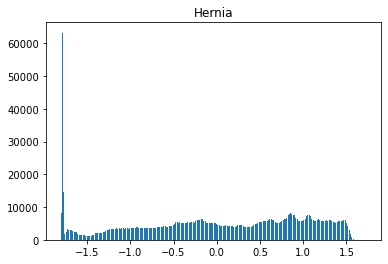

In [79]:

# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Hernia')
plt.show()

### Mass image and intensty plots

In [80]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Mass'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3262,00016094_020.png,Mass,20,16094,025Y,M,PA,2992,2991,0.143,0.143,/data/images_008/images/00016094_020.png
2848,00014125_039.png,Mass,39,14125,028Y,M,PA,2762,2991,0.143,0.143,/data/images_007/images/00014125_039.png
4016,00019786_001.png,Mass,1,19786,046Y,F,PA,2992,2991,0.143,0.143,/data/images_009/images/00019786_001.png


In [81]:
m = sample_df[sample_df['Image Index']=='00011199_000.png']
m


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2174,00011199_000.png,Mass,0,11199,034Y,F,PA,2686,2797,0.143,0.143,/data/images_005/images/00011199_000.png


<function matplotlib.pyplot.show(*args, **kw)>

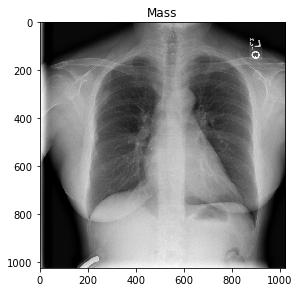

In [82]:
img = io.imread('/data/images_005/images/00011199_000.png')
imgplot = imshow(img)
img_title = plt.title('Mass')
plt.show


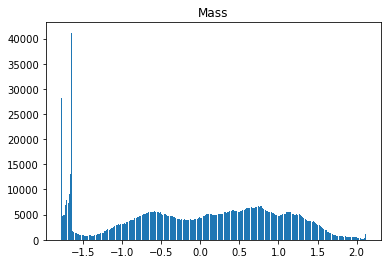

In [83]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Mass')
plt.show()

In [84]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Mass'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1856,00009796_000.png,Mass,0,9796,051Y,F,PA,2048,2500,0.168,0.168,/data/images_005/images/00009796_000.png
5208,00027833_018.png,Mass,18,27833,050Y,M,PA,3056,2544,0.139,0.139,/data/images_011/images/00027833_018.png
3325,00016429_008.png,Mass,8,16429,047Y,F,PA,2674,2991,0.143,0.143,/data/images_008/images/00016429_008.png


In [85]:
m1 = sample_df[sample_df['Image Index']=='00001483_020.png']
m1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
274,00001483_020.png,Mass,20,1483,055Y,F,AP,2500,2048,0.168,0.168,/data/images_002/images/00001483_020.png


<function matplotlib.pyplot.show(*args, **kw)>

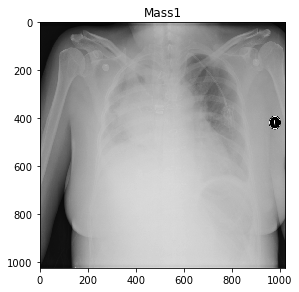

In [86]:
img = io.imread('/data/images_002/images/00001483_020.png')
imgplot = imshow(img)
img_title = plt.title('Mass1')
plt.show

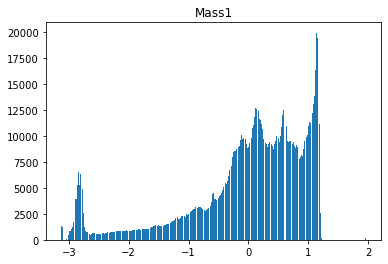

In [87]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Mass1')
plt.show()

### Nodule image and intensty plots

In [88]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Nodule'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
1081,00005682_009.png,Nodule,9,5682,074Y,M,AP,2500,2048,0.171,0.171,/data/images_003/images/00005682_009.png
3315,00016403_001.png,Nodule,1,16403,058Y,M,PA,2992,2991,0.143,0.143,/data/images_008/images/00016403_001.png
1842,00009723_000.png,Nodule,0,9723,051Y,F,PA,2500,2048,0.168,0.168,/data/images_005/images/00009723_000.png


In [89]:
n = sample_df[sample_df['Image Index']=='00028271_003.png']
n

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
5264,00028271_003.png,Nodule,3,28271,056Y,F,PA,2250,2991,0.143,0.143,/data/images_012/images/00028271_003.png


<function matplotlib.pyplot.show(*args, **kw)>

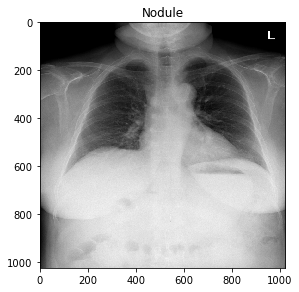

In [90]:
img = io.imread('/data/images_012/images/00028271_003.png')
imgplot = imshow(img)
img_title = plt.title('Nodule')
plt.show



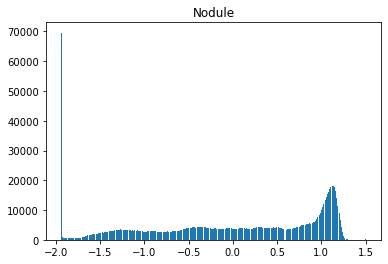

In [91]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Nodule')
plt.show()

In [92]:
n1 = sample_df[sample_df['Image Index']=='00021672_000.png']
n1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
4392,00021672_000.png,Nodule,0,21672,045Y,F,PA,2658,2845,0.143,0.143,/data/images_010/images/00021672_000.png


<function matplotlib.pyplot.show(*args, **kw)>

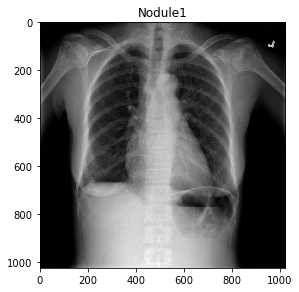

In [93]:
img = io.imread('/data/images_010/images/00021672_000.png')
imgplot = imshow(img)
img_title = plt.title('Nodule1')
plt.show


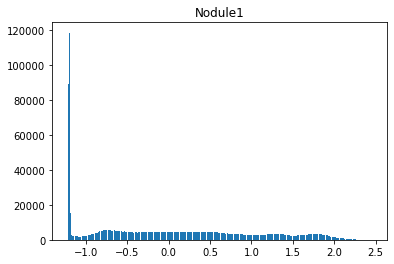

In [94]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Nodule1')
plt.show()

### Pleural_Thickening image and intensty plots

In [95]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pleural_Thickening'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3793,00018627_011.png,Pleural_Thickening,11,18627,056Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00018627_011.png
4779,00025115_000.png,Pleural_Thickening,0,25115,063Y,F,PA,2544,3056,0.139,0.139,/data/images_011/images/00025115_000.png
1913,00010007_057.png,Pleural_Thickening,57,10007,058Y,M,AP,2500,2048,0.168,0.168,/data/images_005/images/00010007_057.png


In [96]:
pt = sample_df[sample_df['Image Index']=='00019437_007.png']
pt

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3941,00019437_007.png,Pleural_Thickening,7,19437,059Y,M,PA,2992,2991,0.143,0.143,/data/images_009/images/00019437_007.png


<function matplotlib.pyplot.show(*args, **kw)>

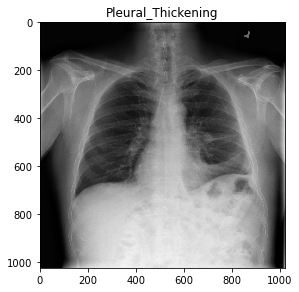

In [97]:
img = io.imread('/data/images_009/images/00019437_007.png')
imgplot = imshow(img)
img_title = plt.title('Pleural_Thickening')
plt.show


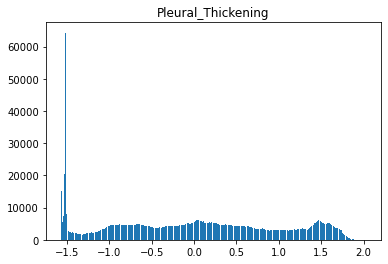

In [98]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pleural_Thickening')
plt.show()

In [99]:
pt1 = sample_df[sample_df['Image Index']=='00012505_005.png']
pt1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2487,00012505_005.png,Pleural_Thickening,5,12505,064Y,F,PA,2992,2991,0.143,0.143,/data/images_006/images/00012505_005.png


<function matplotlib.pyplot.show(*args, **kw)>

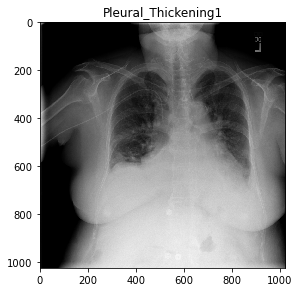

In [100]:
img = io.imread('/data/images_006/images/00012505_005.png')
imgplot = imshow(img)
img_title = plt.title('Pleural_Thickening1')
plt.show

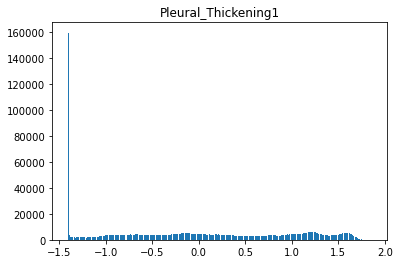

In [101]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pleural_Thickening1')
plt.show()

Pleural thickening have a mode of 5000 and std of -1.5 to +1.5

### Pneumothorax image and intensty plots

In [102]:
# To select images which has been diagnosed with Pneumonia
sample_df[sample_df['Finding Labels']=='Pneumothorax'].sample(3)

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
3475,00017137_008.png,Pneumothorax,8,17137,048Y,F,PA,2990,2991,0.143,0.143,/data/images_008/images/00017137_008.png
3728,00018263_003.png,Pneumothorax,3,18263,052Y,F,PA,2610,2669,0.143,0.143,/data/images_008/images/00018263_003.png
1698,00008841_054.png,Pneumothorax,54,8841,051Y,F,PA,2782,2469,0.143,0.143,/data/images_004/images/00008841_054.png


In [103]:
ptx = sample_df[sample_df['Image Index']=='00002355_002.png']
ptx


,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
440,00002355_002.png,Pneumothorax,2,2355,068Y,F,PA,2670,2991,0.143,0.143,/data/images_002/images/00002355_002.png


<function matplotlib.pyplot.show(*args, **kw)>

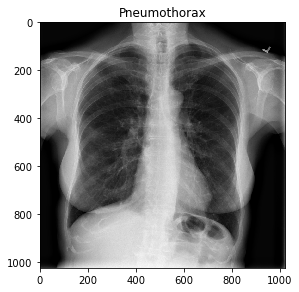

In [104]:
img = io.imread('/data/images_002/images/00002355_002.png')
imgplot = imshow(img)
img_title = plt.title('Pneumothorax')
plt.show


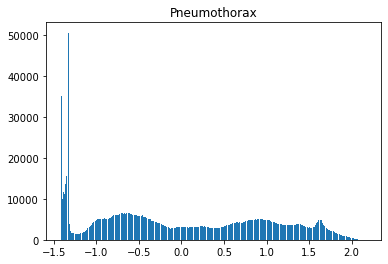

In [105]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumothorax')
plt.show()

In [106]:
ptx1 = sample_df[sample_df['Image Index']=='00011454_003.png']
ptx1

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y,path
2227,00011454_003.png,Pneumothorax,3,11454,017Y,M,AP,2500,2048,0.168,0.168,/data/images_005/images/00011454_003.png


<function matplotlib.pyplot.show(*args, **kw)>

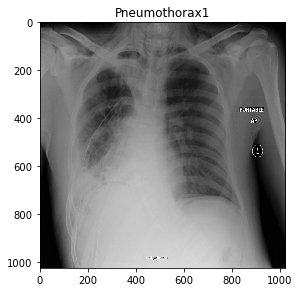

In [107]:
img = io.imread('/data/images_005/images/00011454_003.png')
imgplot = imshow(img)
img_title = plt.title('Pneumothorax1')
plt.show

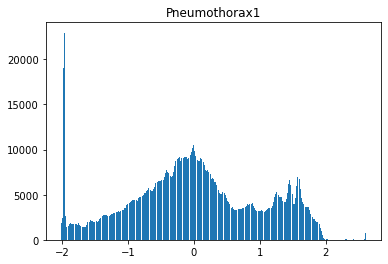

In [108]:
# The corresponding pixel density analysis:
ax = plt.hist(((img - np.mean(img))/np.std(img)).ravel(), bins=300)
img_title = plt.title('Pneumothorax1')
plt.show()

There are diiferneces between the two pneumothoracis because one is treated and the other is not. The mode of untreated is 6000 at -0.7 std. These are 10000 and 0 (at the mean) after tube insertion treatement. 

### Intensity values
To quickly visualize patterns

Infilteration, pneumonia  and consolidation show similar features of intensity that is skewed towards a positive std of 1, but the mode for infiltration peaked at  std of 1-1.3 and that of Pneumonia vary wildy from -1 to 1. 


